In [1]:
import torch
import os
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

import datetime
date_string = str(datetime.date.today())
print(date_string)

dir_name = "./" + date_string + "_result/"
if not os.path.isdir(dir_name):
    os.mkdir(dir_name)
else:
    print(dir_name + "is exist")

print(dir_name)

True
NVIDIA GeForce GTX 1660
2023-06-24
./2023-06-24_result/


In [31]:
#adjusting environment setting
bin_w = 23
bin_h = 37
input_per_bin = 12


overlap_penalty = -90
no_action_reward = -50

print(f"now size: {bin_w} {bin_h}")
print(f"overlap_penalty= {overlap_penalty}, no_action_reward= {no_action_reward}")

now size: 23 37
overlap_penalty= -90, no_action_reward= -50


In [32]:
#functions
def moving_average(lst, move=5):
    moving_averages = []
    for i in range(len(lst)):
        start_idx = max(0, i - move)
        end_idx = min(i + move + 1, len(lst))
        window = lst[start_idx:end_idx]
        average = sum(window) / len(window)
        moving_averages.append(average)

    return moving_averages

In [33]:
#model initial
import numpy as np
import torch
from collections import deque
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy

seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
action_space = bin_w * bin_h +1


In [34]:
def moving_average(lst, move=5):
    moving_averages = []
    for i in range(len(lst)):
        start_idx = max(0, i - move)
        end_idx = min(i + move + 1, len(lst))
        window = lst[start_idx:end_idx]
        average = sum(window) / len(window)
        moving_averages.append(average)

    return moving_averages

# Target network

In [35]:
#random test
from collections import deque
import random
import os
#delete output file last time
try:
    os.remove("test_result_D.txt")
    os.remove("test_result_D_bin.txt")
    os.remove("test_state_D_bin.txt")
    os.remove("show_tree_test.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")


#get all slice info
#file = open("slice_data/full_bin_" + str(bin_w) + "_" + str(bin_h) + "_100.txt",'r')
file = open("shuffle_data/full_bin_" + str(bin_w) + "_" + str(bin_h) + "_100.txt",'r')
#file = open("slice_data/temp_23_37.txt","r")
content = file.read()
file.close
slices = content.split('\n')
#print(slices)
if slices[-1] == "":
    print("empty")
    slices.pop()

#training setting

test_epochs = 100

rewards_test = []

h = 0
#initial state
input_count = 0
shape = (bin_w,bin_h*2,)
#5*5 bin, 0 = empty, 1 = filled
tree_tensor = torch.zeros(shape)
state1_ = tree_tensor.reshape(1,bin_w*bin_h*2)


sync_freq = 500  #每500次將eval model 複製到target model
j=0         #計算500次內的第幾次
total_accept = 0
tree_count = 0
total_accept_test = 0
total_area = 0
PE_per_board_test = []
accept_prob_per_board_test = []
test_state_img = []
test_img = []
for i in range(test_epochs):    
    #if(i%48 == 0):  #clear board
    #random.shuffle(slices)
    #do_clear = 0
    shape = (bin_w,bin_h*2,)
    #5*5 bin, 0 = empty, 1 = filled
    tree_tensor = torch.zeros(shape)
    state1_ = tree_tensor.reshape(1,bin_w*bin_h*2)
    status = 1
    input_count = 0
    accepted_count = 0
    total_area = 0
    while(status == 1): #1 board
      #set state        
      new_slice = slices[input_per_bin*i+input_count].split()
      width = new_slice[0]
      height = new_slice[1]
      width_ = float(width) / 100
      height_ = float(height) / 100
      width = int(width_)
      height = int(height_)
      input_count += 1

      #input slice
      #deploy new
      for index in range(bin_w*bin_h,bin_w*bin_h*2):
        state1_[0,index] = 0
      
      for y in range(height):
        for x in range(width):
          state1_[0,bin_w*bin_h*2-bin_w+x-bin_w*y] = 1

      j+=1

      img = state1_.reshape(bin_h*2 ,-1)
      img_big = torch.zeros(bin_h*2*20,bin_w*20)
      for y in range(bin_w):  #x row, y column
        for x in range(bin_h*2):
          if img[x,y] == 1:
            for a in range(20):
              for b in range(20):
                img_big[x*20+a,y*20+b] = 1
                
      test_state_img.append(img_big)
      
      img_big = img_big.expand(1,bin_h*2*20,bin_w*20)
      

      #select action
      action_ = np.random.randint(0,action_space)


      temp_state1_ = state1_

      #check need deploy?  
      if action_ != bin_w * bin_h : # no action
        #check unvalid 1.out of range 2.overlap
        check_unvalid = 0
        action_column = action_ % bin_w
        if width + action_column -1 > bin_w: #out of right range
          check_unvalid = 1
          
        for y in range(height): #out of top range
          for x in range(width):     
            if action_+x+bin_w*y > bin_w * bin_h -1:
              check_unvalid = 1

        if check_unvalid == 0:
          for y in range(height):
            for x in range(width):
              if state1_[0,action_+x+bin_w*y] == 1:   # 2.overlap
                check_unvalid = 1

        #deploy
        if check_unvalid != 1:
          accepted_count += 1
          total_accept_test += 1
          total_area += width * height
          #deploy
          for y in range(height):
            for x in range(width):
              state1_[0,action_+x+bin_w*y] = 1  
          
        reward = 0
        #calculate reward
        if check_unvalid != 1: #Ok
          check = 0
          cluster_Q = []
          cluster_Q.append(action_)
          #print(cluster_Q)
          while check < len(cluster_Q):
            if cluster_Q[check] - 1 > -1 and cluster_Q[check] - 1 not in cluster_Q: #left
              if state1_[0,cluster_Q[check] - 1] == 1:
                cluster_Q.append(cluster_Q[check] - 1)
            if cluster_Q[check] % bin_w + 1 < bin_w and cluster_Q[check] + 1 not in cluster_Q: #right
              if state1_[0,cluster_Q[check] + 1] == 1:
                cluster_Q.append(cluster_Q[check] + 1)
            if cluster_Q[check] - bin_w > -1 and cluster_Q[check] - bin_w not in cluster_Q: #down 
              if state1_[0,cluster_Q[check] - bin_w] == 1:
                cluster_Q.append(cluster_Q[check] - bin_w)  
            if cluster_Q[check] + bin_w < bin_w * bin_h and cluster_Q[check] + bin_w not in cluster_Q: #up
              if state1_[0,cluster_Q[check] + bin_w] == 1:
                cluster_Q.append(cluster_Q[check] + bin_w)
            check += 1

          #print(cluster_Q,"size = ",len(cluster_Q))
          min_x = 999
          max_x = -1
          min_y = 999
          max_y = -1
          for check in cluster_Q:
            #print("check:",check)
            #get edge of rectangle which can surrond this cluster by using minimal size
            this_y = check // bin_w
            this_x = check % bin_w
            if this_x < min_x:
              min_x = this_x
            if this_x > max_x:
              max_x = this_x
            if this_y < min_y:
              min_y = this_y
            if this_y > max_y:
              max_y = this_y

          #print("x:",min_x,max_x," y:",min_y,max_y)
          compactness = len(cluster_Q) / ((max_x - min_x + 1) * (max_y - min_y + 1))
          #print(compactness)
          reward = len(cluster_Q)*compactness
        else:
          reward = overlap_penalty
      else: #action is 25 no action, calculate special reward
        reward = no_action_reward

      print("reward=",reward)
      rewards_test.append(reward)
      
      state2_ = state1_
      state1_ = temp_state1_

        
      if input_count == input_per_bin:
        accept_prob_per_board_test.append(accepted_count/input_per_bin)
        PE_per_board_test.append(total_area / (bin_w * bin_h))
        
        finish_img = state1_.reshape(bin_h*2,-1)
        """
        finish_img_big = torch.zeros(100,100)
        for y in range(5):
          for x in range(5):
            if finish_img[x,y] == 1:
              for a in range(20):
                for b in range(20):
                  finish_img_big[x*20+a,y*20+b] = 1
        """

        test_img.append(finish_img)
        
        status = 0 #one board done, exit while and clear board


      

      state1_ = state2_
      print("episode:",i)
      clear_output(wait=True)

        

print("total accept rate: ",total_accept_test/(test_epochs*input_per_bin))


total accept rate:  0.3075


total accept rate:  0.3075
average PE:  0.11576968272620448


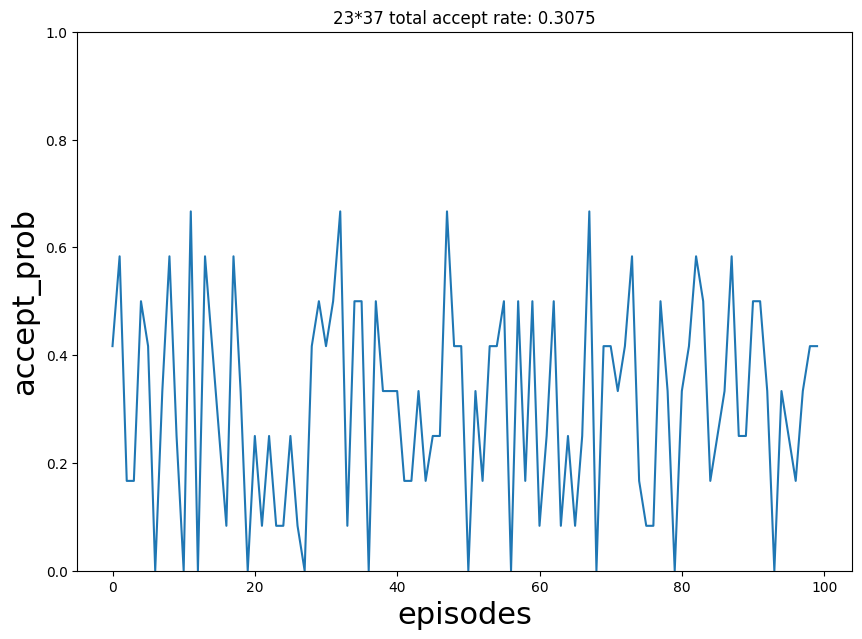

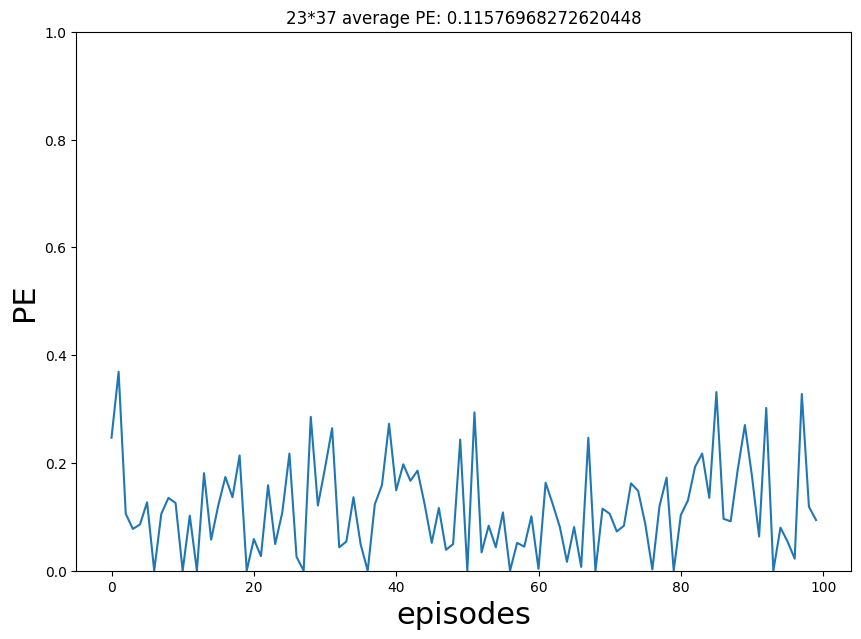

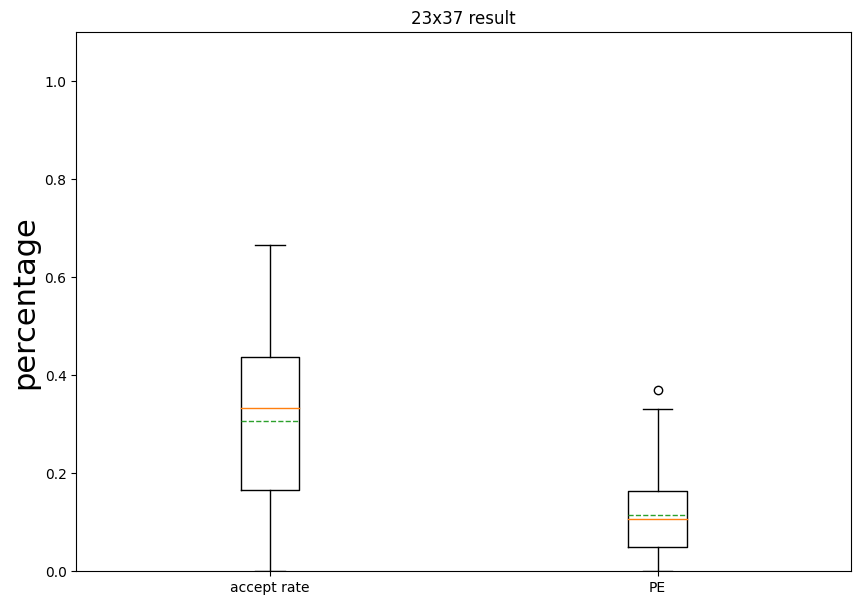

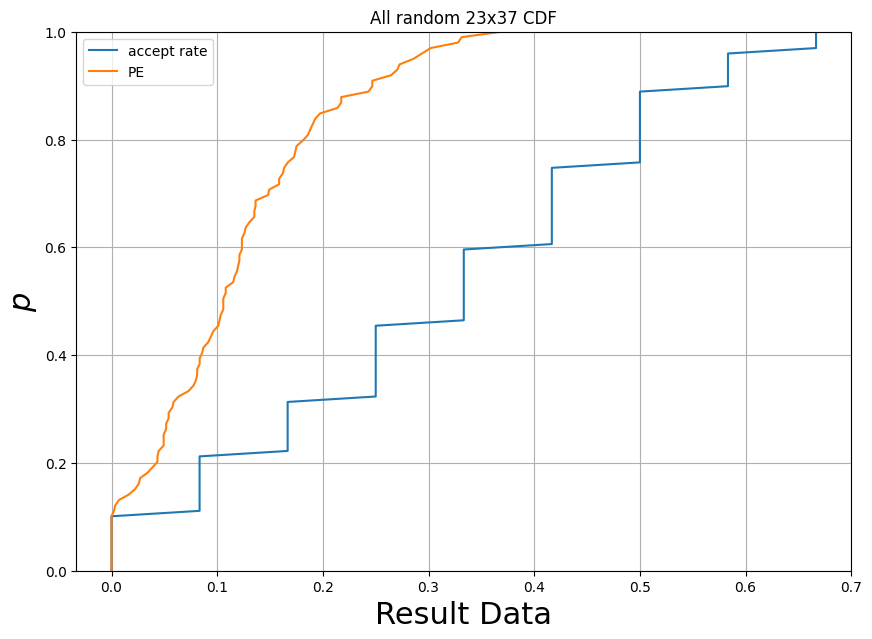

In [36]:
string_accept_prob_per_board_test = str(bin_w) + "*" + str(bin_h) + " total accept rate: " + str(total_accept_test/(test_epochs*input_per_bin))
string_PE_per_board_test = str(bin_w) + "*" + str(bin_h) + " average PE: " +str(sum(PE_per_board_test) / len(PE_per_board_test))

#accept rate plot
plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.plot(accept_prob_per_board_test)
plt.title(string_accept_prob_per_board_test)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("accept_prob",fontsize=22) 
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_accept_prob_per_board.png",dpi=300)

#PE plot
plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.title(string_PE_per_board_test)
plt.plot(PE_per_board_test)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("PE",fontsize=22)
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_PE_per_board.png",dpi=300)

#box plot
plt.figure(figsize=(10,7))
plt.ylim(0,1.1)
x_labels = "accept rate","PE"
plt.boxplot([accept_prob_per_board_test,PE_per_board_test], labels = x_labels, showfliers=True,showmeans = True, meanline = True)
plt.title(str(bin_w) + "x" + str(bin_h) + " result")
plt.ylabel("percentage",fontsize=22) 
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_box.png",dpi=300)

#CDF plot
sorted_accept_prob_per_board_test = copy.deepcopy(accept_prob_per_board_test)
sorted_accept_prob_per_board_test.sort() #sort small to big
p1 = 1. * np.arange(len(sorted_accept_prob_per_board_test)) / (len(sorted_accept_prob_per_board_test) - 1) # calculate the proportional values of samples
sorted_PE_per_board_test = copy.deepcopy(PE_per_board_test)
sorted_PE_per_board_test.sort()
p2 = 1. * np.arange(len(sorted_PE_per_board_test)) / (len(sorted_PE_per_board_test) - 1)

plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.title("All random " + str(bin_w) + "x" + str(bin_h) + " CDF")
plt.plot(sorted_accept_prob_per_board_test, p1)
plt.plot(sorted_PE_per_board_test, p2)
plt.legend(['accept rate','PE']) #mark line's name
plt.xlabel("Result Data", fontsize=22)
plt.ylabel("$p$", fontsize=22)
plt.grid(True)
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_CDF.png",dpi=300)


print("total accept rate: ",total_accept_test/(100*input_per_bin))
print("average PE: ",sum(PE_per_board_test) / len(PE_per_board_test))

import csv
#save data to csv
test_data = zip(["test accept rate"] + accept_prob_per_board_test , ["test PE"] + PE_per_board_test)
test_data = list(test_data)
np.savetxt(dir_name + date_string + "_test_" + str(bin_w) + "x" + str(bin_h) + ".csv",test_data, delimiter =", ", fmt ='% s')

In [37]:
# for item in range(len(test_img)):
#     plt.imshow(test_img[item],cmap='gray')
#     path =   "result img dy/" + str(item+1) + ".png"
#     plt.savefig(path)

In [38]:
# for item in range(len(test_img)):
#     plt.imshow(test_img[item],cmap='gray')
#     path =   "result img every step dy/episode_" + str(item + 1) +"step_13end.png"
#     plt.savefig(path)


In [39]:

# for item in range(len(test_state_img)):
#     plt.imshow(test_state_img[item],cmap='gray')
#     path =   "result img every step dy/episode_" + str(item//input_per_bin+1) +"_step_"+ str(item%input_per_bin+1) + ".png"
    
#     plt.savefig(path)
